In [1]:
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid, save_image
from einops import rearrange
from PIL import Image
import os 
plt.rcParams['figure.figsize'] = [50, 10]
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']


In [11]:
def show(imgs, n_y = 24, n_x=10, dim=64, label=False):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        y = img.shape[1]
        x = img.shape[2]
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        if label:
            border = (x - n_x * dim) / 10
            x_loc = [n * (64 + border) + dim / 2 for n in range(n_x - 2, n_x)]
            y_loc = [n * (64 + border) + dim / 2 for n in range(n_y)]
            y_labels = [fr"$W_{i}$"for i in range(1, len(y_loc))] + ["Diffusion\nProcess",]
            axs[0, i].set(xticklabels=["Generated", "Target"], yticklabels=y_labels, xticks=x_loc, yticks=y_loc)
        else:
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    fig.savefig("test_output.pdf", format="pdf", bbox_inches="tight")

In [12]:
spoof = False
src_dir = "/scratch/work/spieglb1/palette-view-synthesis/logs/2024-01-16T02-00-23-multi-view-composable-variable"
generated_batch = torch.load(os.path.join(src_dir, "generated_batch.pt"), map_location=torch.device("cpu"))
logit_arr = torch.load(os.path.join(src_dir, "logit_arr.pt"), map_location=torch.device("cpu"))
weight_arr = torch.load(os.path.join(src_dir, "weight_arr.pt"), map_location=torch.device("cpu"))
target = torch.load(os.path.join(src_dir, "target.pt"), map_location=torch.device("cpu"))
cond = torch.load(os.path.join(src_dir, "cond.pt"), map_location=torch.device("cpu"))


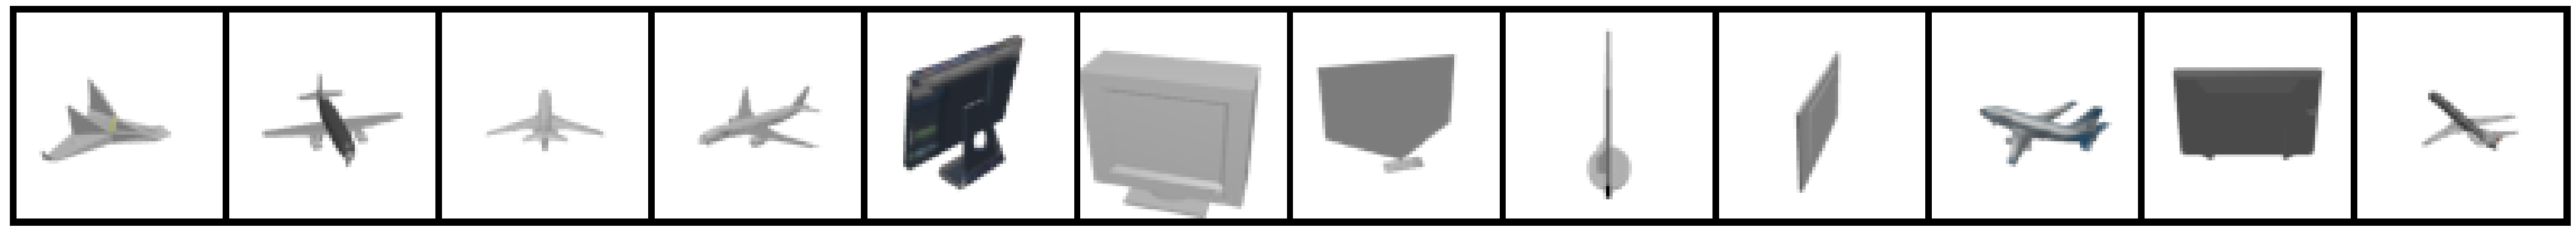

In [13]:
target_grid = make_grid(target, nrow=12)
show(target_grid)

In [14]:
cond.shape
weight_arr.shape

torch.Size([12, 8, 6, 3, 64, 64])

torch.Size([9, 7, 3, 64, 64])
torch.Size([1, 7, 3, 64, 64])
torch.Size([3, 464, 662])


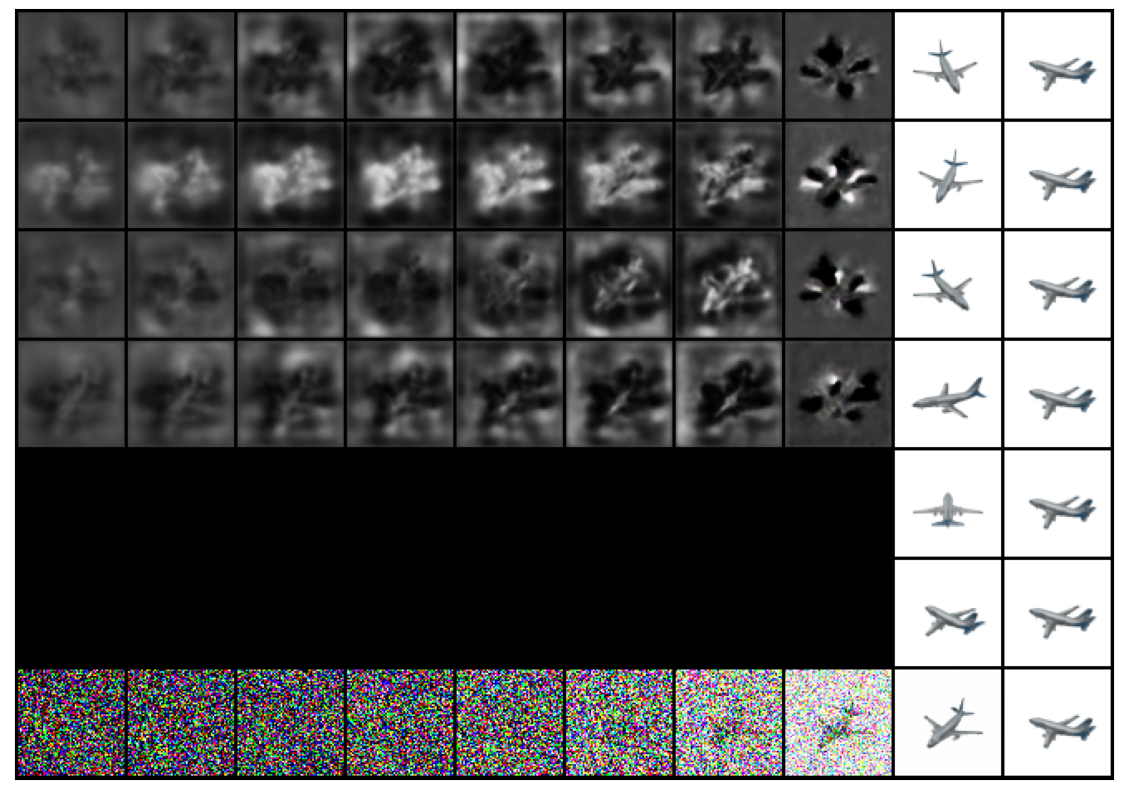

In [26]:
i = 9
target_grid = torch.cat([target[i, ...][None, ...],] * (weight_arr.shape[2] + 1))[None, ...]
view_weights = torch.cat((weight_arr[i, ...], cond[i, :weight_arr.shape[2], :3, ...][None, ...]), dim=0)
view_weights = torch.cat((view_weights, torch.clamp(generated_batch[i, ...][:, None, ...], 0, 1)), dim=1)
print(view_weights.shape)
print(target_grid.shape)
view_weights = torch.cat((view_weights, target_grid))
view_weights = make_grid(rearrange(view_weights, "s v c h w -> (v s) c h w"), nrow=view_weights.shape[0], scale_each=True)
save_image(view_weights, "architecture_sample.png")
print(view_weights.shape)
show(view_weights)

In [27]:
n = 9
variable_generated_batch = torch.load(os.path.join(src_dir, f"variable_generated_batch_{n}.pt"), map_location=torch.device("cpu"))
variable_logit_arr = torch.load(os.path.join(src_dir, f"variable_logit_arr_{n}.pt"), map_location=torch.device("cpu"))
variable_weight_arr = torch.load(os.path.join(src_dir, f"variable_weight_arr_{n}.pt"), map_location=torch.device("cpu"))
target = torch.load(os.path.join(src_dir, "target.pt"), map_location=torch.device("cpu"))

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/work/spieglb1/palette-view-synthesis/logs/2024-01-16T02-00-23-multi-view-composable-variable/variable_generated_batch_9.pt'

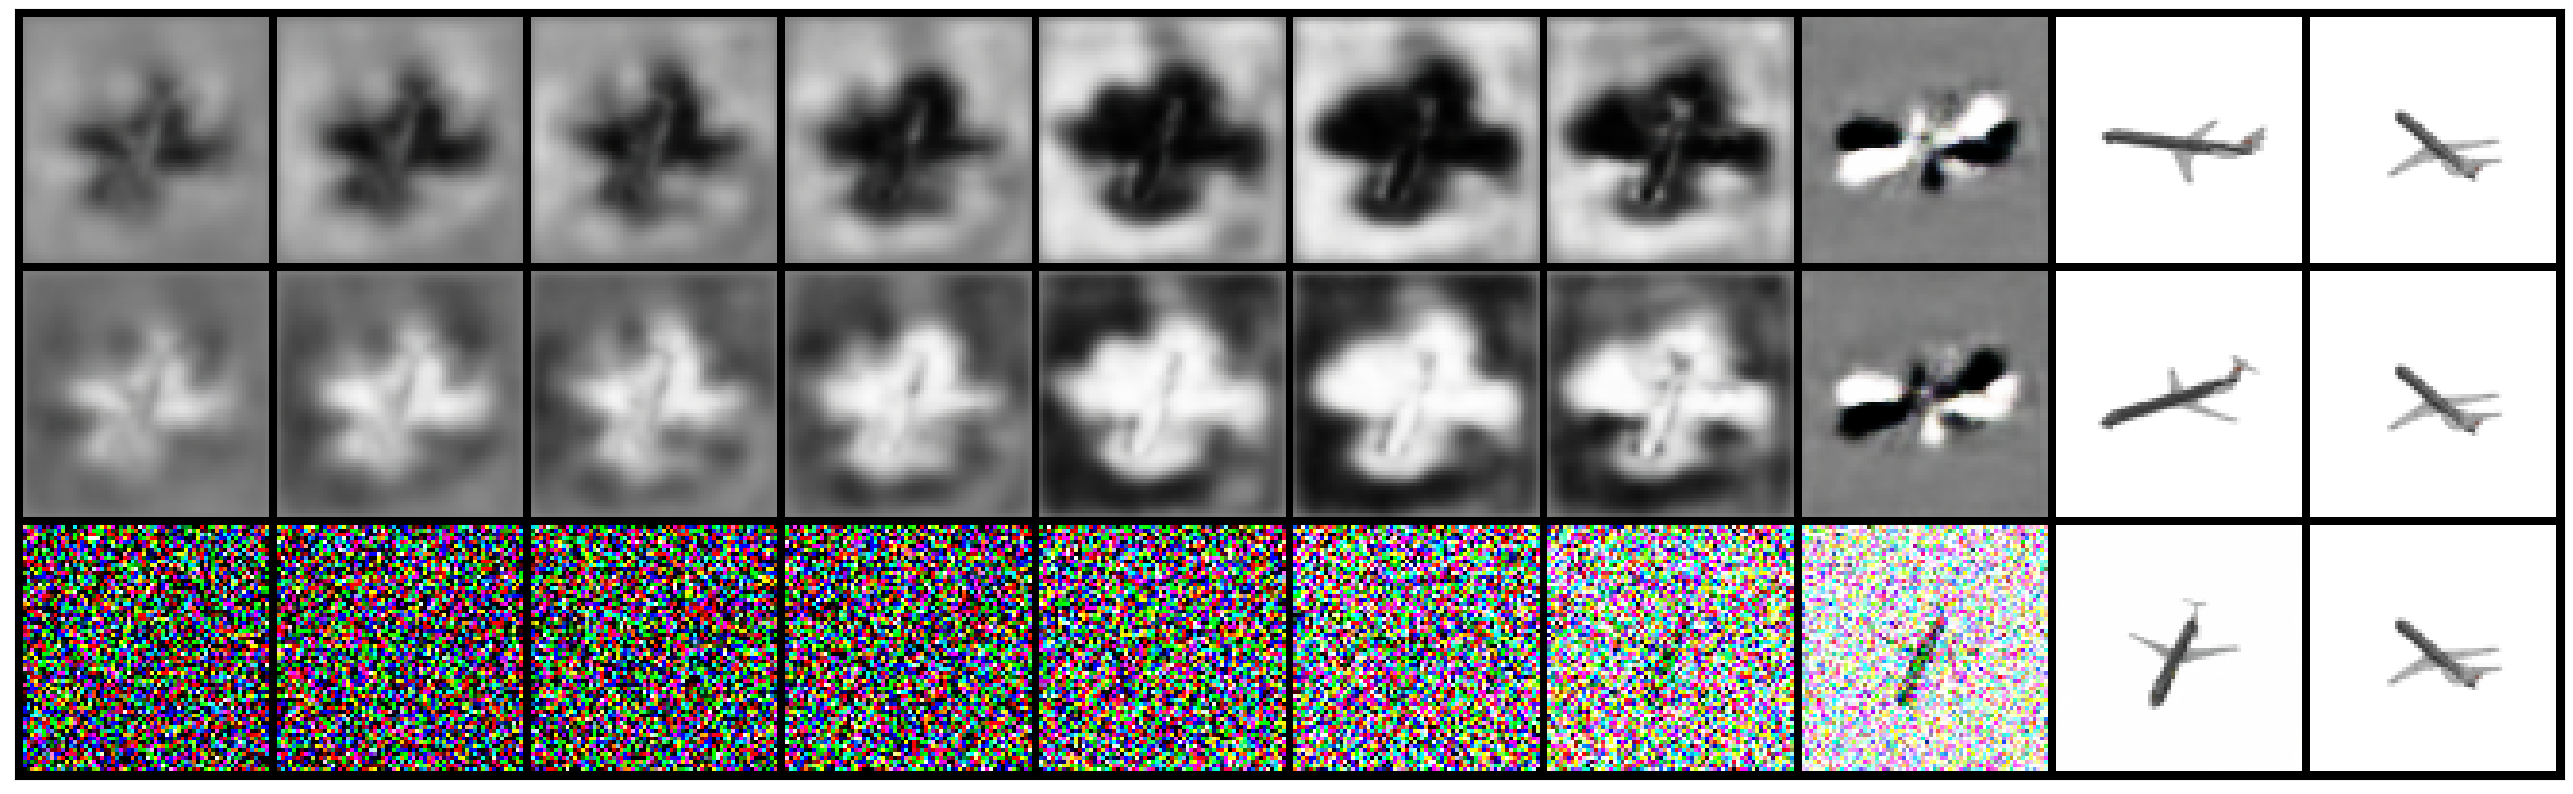

In [25]:
i = 11
target_grid = torch.cat([target[i, ...][None, ...],] * (variable_weight_arr.shape[2] + 1))[None, ...]
view_weights = torch.cat((variable_weight_arr[i, ...], cond[i, :variable_weight_arr.shape[2], :3, ...][None, ...]), dim=0)
view_weights = torch.cat((view_weights, torch.clamp(variable_generated_batch[i, ...][:, None, ...], 0, 1)), dim=1)
view_weights = torch.cat((view_weights, target_grid))
view_weights = make_grid(rearrange(view_weights, "s v c h w -> (v s) c h w"), nrow=view_weights.shape[0], scale_each=True)
show(view_weights, n_y=variable_weight_arr.shape[2]+1)